In [16]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.metrics import accuracy_score, confusion_matrix, RocCurveDisplay
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA, FastICA
from sklearn.random_projection import GaussianRandomProjection
from keras.models import Sequential
from keras.layers import Dense, Input, Dropout
from scikeras.wrappers import KerasClassifier
from keras.optimizers import SGD
from tensorflow.keras.constraints import max_norm
from warnings import filterwarnings
filterwarnings('ignore')

# 1. Preprocessing

In [17]:
bike_df = pd.read_csv('C:/Users/adity/SeoulBikeData.csv', encoding='latin-1')

bike_df.columns = ['date', 'bike_count', 'hour', 'temperature', 'humidity', 'wind_speed', 'visibility', 'dew_point_temp', 
                   'solar_radiation', 'rainfall', 'snowfall', 'season', 'holiday', 'functioning_day']

bike_df['date'] = pd.to_datetime(bike_df['date'], format = '%d/%m/%Y')
bike_df['hour'] = bike_df['hour'].astype('category')
bike_df['season'] = bike_df['season'].astype('category')
bike_df['holiday'] = bike_df['holiday'].astype('category')
bike_df['functioning_day'] = bike_df['functioning_day'].astype('category')
bike_df['day'] = bike_df['date'].dt.day_name().astype('category')
bike_df['class']  = bike_df['bike_count'] > np.median(bike_df['bike_count'])

bike_df = bike_df[bike_df['functioning_day'] == 'Yes']
bike_df = bike_df.drop(['date', 'functioning_day', 'dew_point_temp'], axis = 1)
bike_df = bike_df.reset_index(drop = True)

bike_df.head()

,bike_count,hour,temperature,humidity,wind_speed,visibility,solar_radiation,rainfall,snowfall,season,holiday,day,class
0,254,0,-5.2,37,2.2,2000,0.0,0.0,0.0,Winter,No Holiday,Friday,False
1,204,1,-5.5,38,0.8,2000,0.0,0.0,0.0,Winter,No Holiday,Friday,False
2,173,2,-6.0,39,1.0,2000,0.0,0.0,0.0,Winter,No Holiday,Friday,False
3,107,3,-6.2,40,0.9,2000,0.0,0.0,0.0,Winter,No Holiday,Friday,False
4,78,4,-6.0,36,2.3,2000,0.0,0.0,0.0,Winter,No Holiday,Friday,False


In [18]:
full_df = bike_df

full_ddf = pd.get_dummies(full_df['hour'], drop_first = True, prefix = 'hour:')
full_ddf = pd.concat([full_ddf, pd.get_dummies(full_df['day'], drop_first = True, prefix = 'day:')], axis = 1)
full_ddf = pd.concat([full_ddf, pd.get_dummies(full_df['season'], drop_first = True, prefix = 'season:')], axis = 1)
full_ddf = pd.concat([full_ddf, pd.get_dummies(full_df['holiday'],  prefix = 'holiday:')], axis = 1)
full_ddf = full_ddf.drop('holiday:_No Holiday', axis = 1)

full_df = full_df.drop(['hour', 'day', 'season', 'holiday', 'bike_count'], axis = 1)

c = bike_df['class']

full_df = full_df.drop('class', axis = 1)

def featureNormalize(X):
    return (X - np.mean(X, axis = 0)) / np.std(X, axis = 0, ddof = 1)

X = pd.concat([featureNormalize(full_df), full_ddf], axis = 1).reset_index(drop = True)

In [19]:
random.seed(42)
X_train = X.sample(frac = 0.7).sort_index()
c_train = c[X.index.isin(X_train.index)]
X_test = X[~X.index.isin(X_train.index)]
c_test = c[~X.index.isin(X_train.index)]

# 2. K-Means

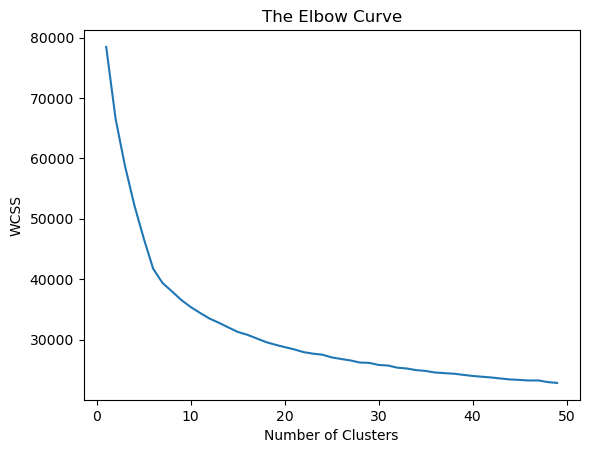

In [20]:
wcss = []
for i in range(1, 50):
    kmeans_arr = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans_arr.fit(X)
    wcss.append(kmeans_arr.inertia_)
plt.plot(range(1, 50), wcss)
plt.title('The Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [21]:
kmeans = KMeans(n_clusters = 10, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
kmeans.fit(X)
print('WCSS: {:.2f}'.format(kmeans.inertia_))
print(np.unique(kmeans.labels_, return_counts = True))

WCSS: 35375.02
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([1681, 1385, 1024,  847,  169, 1322,  116,  853, 1049,   19],
      dtype=int64))


In [22]:
X_kmeans = X.copy()
X_kmeans['cluster'] = kmeans.labels_
X_kmeans = pd.concat([X_kmeans, pd.get_dummies(X_kmeans['cluster'], drop_first = True, prefix = 'cluster:')], axis = 1)
X_kmeans = X_kmeans.drop(['cluster'], axis = 1)
X_train_kmeans = X_kmeans[X_kmeans.index.isin(X_train.index)]
X_test_kmeans = X_kmeans[~X_kmeans.index.isin(X_train.index)]

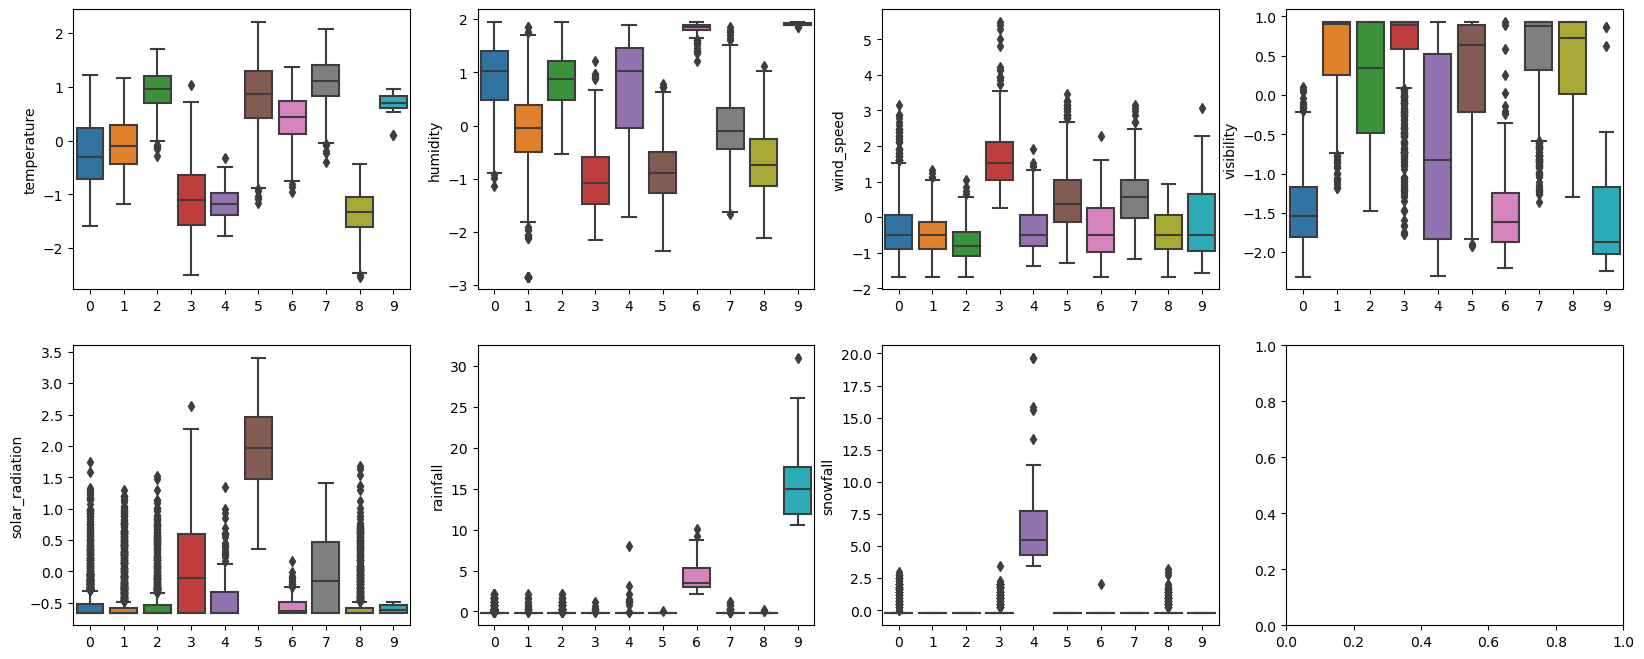

In [23]:
fig, axes = plt.subplots(nrows = 2, ncols = 4, figsize = (20, 8))
for i, ax in enumerate(zip(['temperature', 'humidity', 'wind_speed', 'visibility', 
                            'solar_radiation', 'rainfall', 'snowfall'], fig.axes)):
    sns.boxplot(y = X[ax[0]], x = kmeans.labels_, ax = ax[1])

In [24]:
bike_df['cluster'] = kmeans.labels_
bike_df.groupby(['cluster', 'class'])['bike_count'].count().reset_index().pivot('cluster', 'class', 'bike_count')

class,False,True
cluster,,
0,1143,538
1,548,837
2,402,622
3,644,203
4,166,3
5,55,1267
6,112,4
7,59,794
8,938,111


## ANN Model

In [25]:
def create_model1(neurons = 0):
    model = Sequential()
    model.add(Input(shape = (49, )))
    model.add(Dense(neurons, activation = 'relu', kernel_constraint = max_norm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = SGD(learning_rate = 0.1, momentum = 0.1)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

neurons = [1, 5, 10, 15, 20, 25, 30]

# Create a list to hold the results
results = []

# Iterate over the learning rates and momentums
for n in neurons:
    # Create the KerasClassifier
    nnc1_model = KerasClassifier(build_fn=create_model1, batch_size=10, epochs=100, verbose=0, neurons = n)
    
    # Perform K-fold cross-validation and get train and test scores
    cv_results = cross_validate(nnc1_model, X_train_kmeans.values, c_train.values.ravel(), cv=5,
                                return_train_score=True, return_estimator=True)

    train_scores = cv_results['train_score']
    test_scores = cv_results['test_score']

    # Calculate the mean of the scores
    mean_train_score = np.mean(train_scores)
    mean_test_score = np.mean(test_scores)

    # Append the result to the list
    results.append((n, mean_train_score, mean_test_score))


# Convert to DataFrame and Print the results
nnc1_df = pd.DataFrame(results, columns = ['neurons', 'train_score', 'test_score'])

Best Parameters: {Neurons [5] }
Best Cross-Validation Accuracy: 0.86


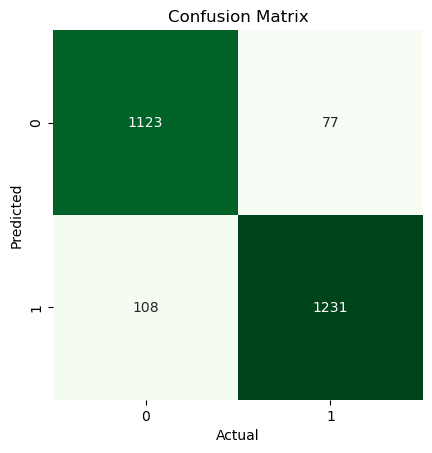

Accuracy: 0.93
Sensitivity: 0.94
Specificity: 0.91


In [26]:
# Find the maximum score value
max_score = nnc1_df['test_score'].max()

# Filter the rows with the maximum score value
best_nnc1 = nnc1_df[nnc1_df['test_score'] == max_score]

# Extract the 'pred' column and convert it to a numpy array
best_n = best_nnc1['neurons'].values.ravel()

print('Best Parameters: {Neurons', best_n, '}')
print('Best Cross-Validation Accuracy: {:.2f}'.format(max_score))

nnc1 = KerasClassifier(build_fn=create_model1, batch_size=10, epochs=100, verbose=0, neurons = best_n)

nnc1.fit(X_train_kmeans.values, c_train.values.ravel())

pred_nnc1 = nnc1.predict(X_test_kmeans)

cm_nnc1 = confusion_matrix(c_test, pred_nnc1)
tn, fp, fn, tp = cm_nnc1.ravel()

ax = sns.heatmap(cm_nnc1.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_nnc1)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

# 3. Dimensionality Reduction Techniques

## 3.1. Random Forest

In [27]:
random.seed(0)

rf = RandomForestClassifier() 
rf.fit(X_train, c_train.values.ravel()) 

pd.DataFrame({'feature' : [i.split(':', 1)[0] for i in X_train.columns],
                'importance' : rf.feature_importances_}).groupby('feature').sum().sort_values('importance', ascending = False)

,importance
feature,
hour,0.220418
temperature,0.218455
season,0.187086
solar_radiation,0.096859
humidity,0.096491
visibility,0.047786
wind_speed,0.044375
day,0.042900
rainfall,0.031581


In [28]:
top_var_list = ['temperature', 'hour', 'season', 'humidity', 'solar_radiation']

top_df = bike_df[top_var_list]
top_ddf = pd.get_dummies(top_df['hour'], drop_first = True, prefix = 'hour:')
top_ddf = pd.concat([top_ddf, pd.get_dummies(top_df['season'], drop_first = True, prefix = 'season:')], axis = 1)

top_df = top_df.drop(['hour', 'season'], axis = 1)

X_rf = pd.concat([featureNormalize(top_df), top_ddf], axis = 1).reset_index(drop = True)

In [29]:
X_train_rf = X_rf[X_rf.index.isin(X_train.index)]
X_test_rf = X_rf[~X_rf.index.isin(X_train.index)]

## ANN Model

In [30]:
def create_model2(neurons = 0):
    model = Sequential()
    model.add(Input(shape = (29, )))
    model.add(Dense(neurons, activation = 'relu', kernel_constraint = max_norm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = SGD(learning_rate = 0.1, momentum = 0.1)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

neurons = [1, 5, 10, 15, 20, 25, 30]

# Create a list to hold the results
results = []

# Iterate over the learning rates and momentums
for n in neurons:
    # Create the KerasClassifier
    nnc2_model = KerasClassifier(build_fn=create_model2, batch_size=10, epochs=100, verbose=0, neurons = n)
    
    # Perform K-fold cross-validation and get train and test scores
    cv_results = cross_validate(nnc2_model, X_train_rf.values, c_train.values.ravel(), cv=5,
                                return_train_score=True, return_estimator=True)

    train_scores = cv_results['train_score']
    test_scores = cv_results['test_score']

    # Calculate the mean of the scores
    mean_train_score = np.mean(train_scores)
    mean_test_score = np.mean(test_scores)

    # Append the result to the list
    results.append((n, mean_train_score, mean_test_score))


# Convert to DataFrame and Print the results
nnc2_df = pd.DataFrame(results, columns = ['neurons', 'train_score', 'test_score'])

Best Parameters: {Neurons [1] }
Best Cross-Validation Accuracy: 0.85


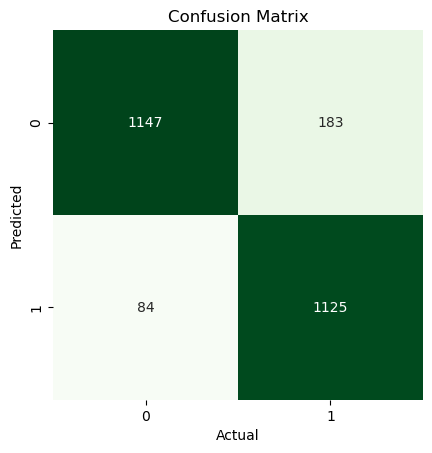

Accuracy: 0.89
Sensitivity: 0.86
Specificity: 0.93


In [31]:
# Find the maximum score value
max_score = nnc2_df['test_score'].max()

# Filter the rows with the maximum score value
best_nnc2 = nnc2_df[nnc2_df['test_score'] == max_score]

# Extract the 'pred' column and convert it to a numpy array
best_n = best_nnc2['neurons'].values.ravel()

print('Best Parameters: {Neurons', best_n, '}')
print('Best Cross-Validation Accuracy: {:.2f}'.format(max_score))

nnc2 = KerasClassifier(build_fn=create_model2, batch_size=10, epochs=100, verbose=0, neurons = best_n)

nnc2.fit(X_train_rf.values, c_train.values.ravel())

pred_nnc2 = nnc2.predict(X_test_rf)

cm_nnc2 = confusion_matrix(c_test, pred_nnc2)
tn, fp, fn, tp = cm_nnc2.ravel()

ax = sns.heatmap(cm_nnc2.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_nnc2)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

## 3.2. Principal Component Analysis

In [32]:
pca = PCA(random_state = 0)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
np.round(pca.explained_variance_ratio_ * 100, 2)

array([2.301e+01, 1.650e+01, 1.160e+01, 9.420e+00, 8.390e+00, 6.810e+00,
       2.600e+00, 2.540e+00, 1.590e+00, 1.570e+00, 1.560e+00, 1.520e+00,
       1.500e+00, 7.000e-01, 5.300e-01, 4.800e-01, 4.700e-01, 4.700e-01,
       4.700e-01, 4.600e-01, 4.600e-01, 4.600e-01, 4.600e-01, 4.500e-01,
       4.500e-01, 4.500e-01, 4.500e-01, 4.500e-01, 4.500e-01, 4.400e-01,
       4.400e-01, 4.400e-01, 4.400e-01, 4.400e-01, 4.300e-01, 4.300e-01,
       2.800e-01, 2.200e-01, 1.400e-01, 2.000e-02])

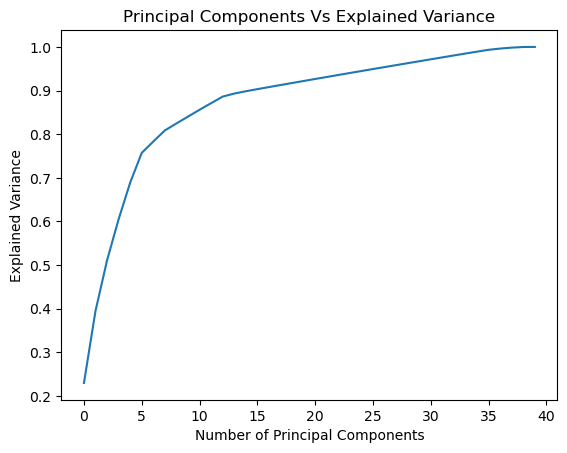

In [33]:
plt.plot(range(len(pca.explained_variance_ratio_ )), np.cumsum(pca.explained_variance_ratio_))
plt.title('Principal Components Vs Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.show()

In [34]:
labels = {
    str(i): f"PC {i + 1} ({var:.1f}%)"
    for i, var in enumerate(pca.explained_variance_ratio_ * 100)
}

fig = px.scatter_matrix(X_train_pca, labels = labels, dimensions = range(6), color = c_train)
fig.update_traces(diagonal_visible = False)
fig.update_layout(autosize = False, width = 900, height = 900)
fig.show()

## ANN Model

In [35]:
def create_model3(neurons = 0):
    model = Sequential()
    model.add(Input(shape = (13, )))
    model.add(Dense(neurons, activation = 'relu', kernel_constraint = max_norm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = SGD(learning_rate = 0.1, momentum = 0.1)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

neurons = [1, 5, 10, 15, 20, 25, 30]

# Create a list to hold the results
results = []

# Iterate over the learning rates and momentums
for n in neurons:
    # Create the KerasClassifier
    nnc3_model = KerasClassifier(build_fn=create_model3, batch_size=10, epochs=100, verbose=0, neurons = n)
    
    # Perform K-fold cross-validation and get train and test scores
    cv_results = cross_validate(nnc3_model, X_train_pca[:,:13], c_train.values.ravel(), cv=5,
                                return_train_score=True, return_estimator=True)

    train_scores = cv_results['train_score']
    test_scores = cv_results['test_score']

    # Calculate the mean of the scores
    mean_train_score = np.mean(train_scores)
    mean_test_score = np.mean(test_scores)

    # Append the result to the list
    results.append((n, mean_train_score, mean_test_score))


# Convert to DataFrame and Print the results
nnc3_df = pd.DataFrame(results, columns = ['neurons', 'train_score', 'test_score'])

Best Parameters: {Neurons [1] }
Best Cross-Validation Accuracy: 0.74


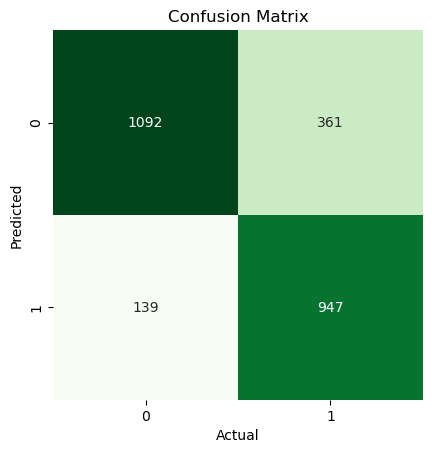

Accuracy: 0.80
Sensitivity: 0.72
Specificity: 0.89


In [36]:
# Find the maximum score value
max_score = nnc3_df['test_score'].max()

# Filter the rows with the maximum score value
best_nnc3 = nnc3_df[nnc3_df['test_score'] == max_score]

# Extract the 'pred' column and convert it to a numpy array
best_n = best_nnc3['neurons'].values.ravel()

print('Best Parameters: {Neurons', best_n, '}')
print('Best Cross-Validation Accuracy: {:.2f}'.format(max_score))

nnc3 = KerasClassifier(build_fn=create_model3, batch_size=10, epochs=100, verbose=0, neurons = best_n)

nnc3.fit(X_train_pca[:,:13], c_train.values.ravel())

pred_nnc3 = nnc3.predict(X_test_pca[:,:13])

cm_nnc3 = confusion_matrix(c_test, pred_nnc3)
tn, fp, fn, tp = cm_nnc3.ravel()

ax = sns.heatmap(cm_nnc3.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_nnc3)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

## 3.3. Independent Component Analysis

In [37]:
ica = FastICA(max_iter = 1000, tol=1e-4, algorithm='deflation', random_state = 0)
X_train_ica = ica.fit_transform(X_train)
X_train_ica_df = pd.DataFrame(X_train_ica)
X_test_ica = ica.transform(X_test)

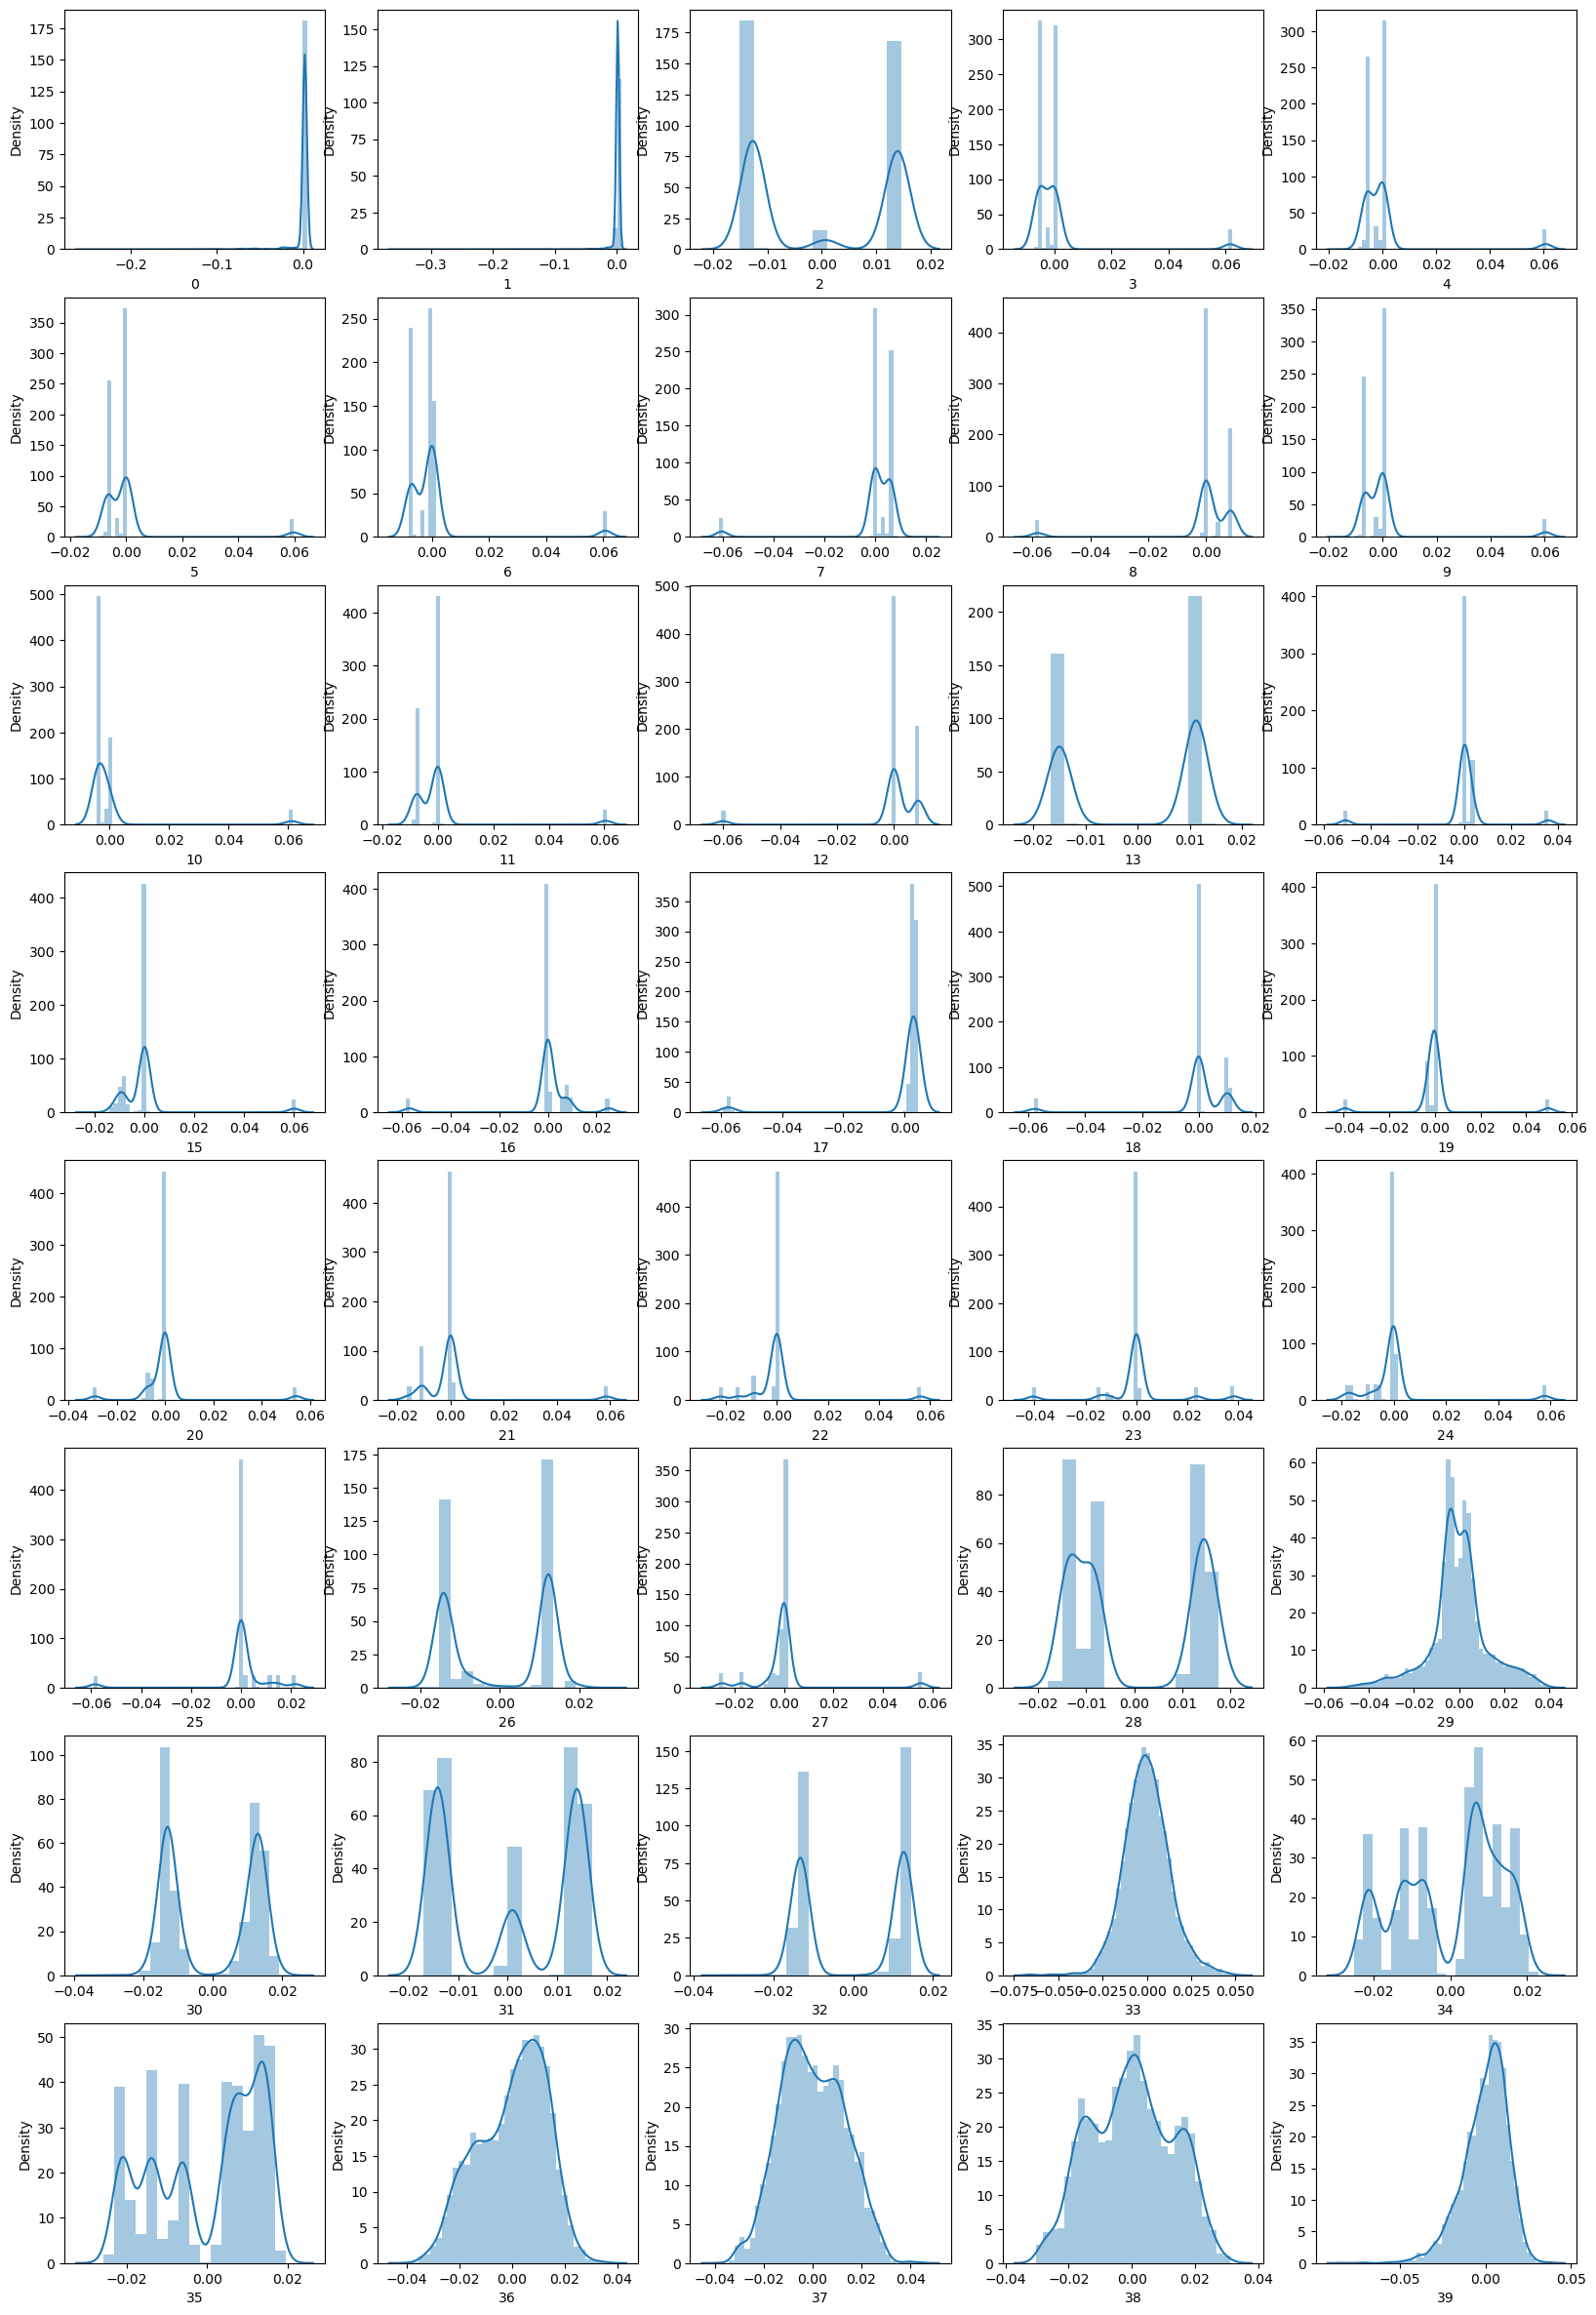

In [38]:
fig, axes = plt.subplots(nrows = 8, ncols = 5, figsize = (20, 30))
for i, ax in enumerate(zip(X_train_ica_df.columns, fig.axes)):
    sns.distplot(X_train_ica_df[ax[0]], ax = ax[1])

# 4. Cluster Analysis on Dimensionality Reduction Algorithms

## 4.1. k-Means on Features Selected using Random Forest

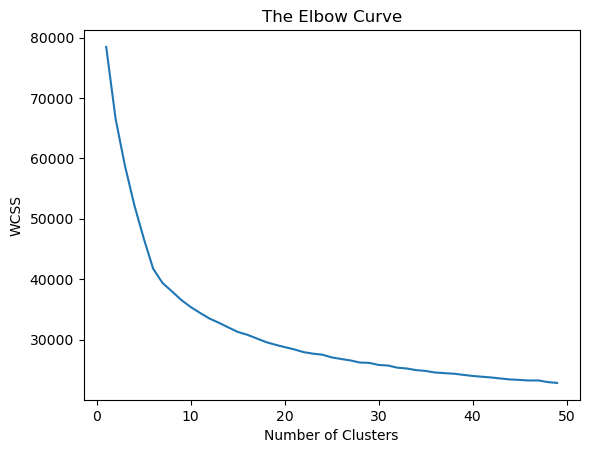

In [39]:
wcss_rf = []
for i in range(1, 50):
    kmeans_arr = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans_arr.fit(X_rf)
    wcss_rf.append(kmeans_arr.inertia_)
plt.plot(range(1, 50), wcss)
plt.title('The Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [40]:
kmeans_rf = KMeans(n_clusters = 10, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
kmeans_rf.fit(X_rf)
print('WCSS: {:.2f}'.format(kmeans_rf.inertia_))
print(np.unique(kmeans_rf.labels_, return_counts = True))

WCSS: 13380.28
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 626,  740,  597, 1069, 1017,  516,  477,  889, 1258, 1276],
      dtype=int64))


In [41]:
X_kmeans_rf = X_rf.copy()
X_kmeans_rf['cluster'] = kmeans_rf.labels_
X_kmeans_rf = pd.concat([X_kmeans_rf, 
                         pd.get_dummies(X_kmeans_rf['cluster'], drop_first = True, prefix = 'cluster:')], axis = 1)
X_kmeans_rf = X_kmeans_rf.drop(['cluster'], axis = 1)
X_train_kmeans_rf = X_kmeans_rf[X_kmeans_rf.index.isin(X_train.index)]
X_test_kmeans_rf = X_kmeans_rf[~X_kmeans_rf.index.isin(X_train.index)]

## ANN Model

In [42]:
def create_model4(neurons = 0):
    model = Sequential()
    model.add(Input(shape = (38, )))
    model.add(Dense(neurons, activation = 'relu', kernel_constraint = max_norm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = SGD(learning_rate = 0.1, momentum = 0.1)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

neurons = [1, 5, 10, 15, 20, 25, 30]

# Create a list to hold the results
results = []

# Iterate over the learning rates and momentums
for n in neurons:
    # Create the KerasClassifier
    nnc4_model = KerasClassifier(build_fn=create_model4, batch_size=10, epochs=100, verbose=0, neurons = n)
    
    # Perform K-fold cross-validation and get train and test scores
    cv_results = cross_validate(nnc4_model, X_train_kmeans_rf.values, c_train.values.ravel(), cv=5,
                                return_train_score=True, return_estimator=True)

    train_scores = cv_results['train_score']
    test_scores = cv_results['test_score']

    # Calculate the mean of the scores
    mean_train_score = np.mean(train_scores)
    mean_test_score = np.mean(test_scores)

    # Append the result to the list
    results.append((n, mean_train_score, mean_test_score))


# Convert to DataFrame and Print the results
nnc4_df = pd.DataFrame(results, columns = ['neurons', 'train_score', 'test_score'])

Best Parameters: {Neurons [1] }
Best Cross-Validation Accuracy: 0.82


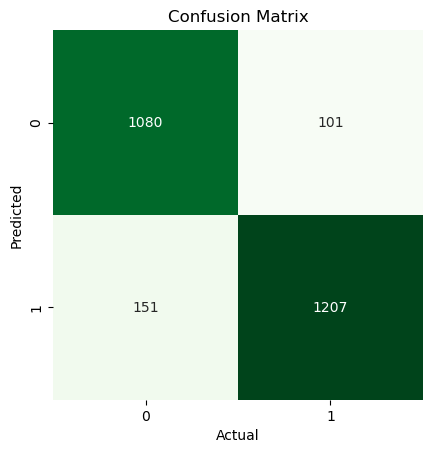

Accuracy: 0.90
Sensitivity: 0.92
Specificity: 0.88


In [43]:
# Find the maximum score value
max_score = nnc4_df['test_score'].max()

# Filter the rows with the maximum score value
best_nnc4 = nnc4_df[nnc4_df['test_score'] == max_score]

# Extract the 'pred' column and convert it to a numpy array
best_n = best_nnc4['neurons'].values.ravel()

print('Best Parameters: {Neurons', best_n, '}')
print('Best Cross-Validation Accuracy: {:.2f}'.format(max_score))

nnc4 = KerasClassifier(build_fn=create_model4, batch_size=10, epochs=100, verbose=0, neurons = best_n)

nnc4.fit(X_train_kmeans_rf.values, c_train.values.ravel())

pred_nnc4 = nnc4.predict(X_test_kmeans_rf)

cm_nnc4 = confusion_matrix(c_test, pred_nnc4)
tn, fp, fn, tp = cm_nnc4.ravel()

ax = sns.heatmap(cm_nnc4.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_nnc4)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

## 4.2. k-Means on PCA Features

In [44]:
pca2 = PCA(random_state = 0)
X_kmeans_pca = pca2.fit_transform(X)
np.round(pca2.explained_variance_ratio_ * 100, 2)

array([2.306e+01, 1.642e+01, 1.152e+01, 9.880e+00, 8.290e+00, 6.750e+00,
       2.600e+00, 2.520e+00, 1.580e+00, 1.550e+00, 1.530e+00, 1.520e+00,
       1.480e+00, 6.800e-01, 5.300e-01, 4.600e-01, 4.500e-01, 4.500e-01,
       4.500e-01, 4.500e-01, 4.500e-01, 4.500e-01, 4.500e-01, 4.500e-01,
       4.500e-01, 4.500e-01, 4.500e-01, 4.500e-01, 4.500e-01, 4.500e-01,
       4.500e-01, 4.500e-01, 4.500e-01, 4.500e-01, 4.500e-01, 4.400e-01,
       2.800e-01, 2.200e-01, 1.400e-01, 2.000e-02])

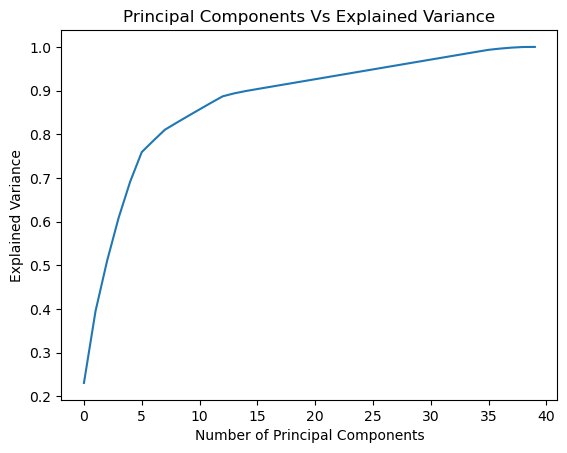

In [45]:
plt.plot(range(len(pca2.explained_variance_ratio_ )), np.cumsum(pca2.explained_variance_ratio_))
plt.title('Principal Components Vs Explained Variance')
plt.xlabel('Number of Principal Components')
plt.ylabel('Explained Variance')
plt.show()

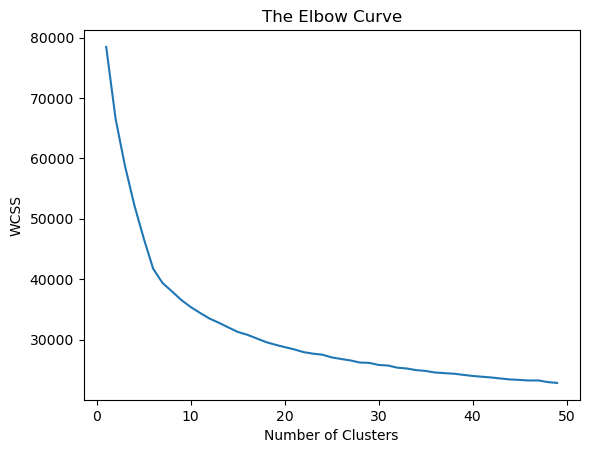

In [46]:
wcss_pca = []
for i in range(1, 50):
    kmeans_arr = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    kmeans_arr.fit(X_kmeans_pca[:,:13])
    wcss_rf.append(kmeans_arr.inertia_)
plt.plot(range(1, 50), wcss)
plt.title('The Elbow Curve')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [47]:
kmeans_pca = KMeans(n_clusters = 10, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
kmeans_pca.fit(X_kmeans_pca[:,:13])
print('WCSS: {:.2f}'.format(kmeans_pca.inertia_))
print(np.unique(kmeans_pca.labels_, return_counts = True))

WCSS: 26655.37
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([ 718, 1578, 1369, 1453,  749,  167,  109,  788, 1515,   19],
      dtype=int64))


In [48]:
X_kmeans_pca_df = pd.DataFrame(X_kmeans_pca[:,:13])
X_kmeans_pca_df['cluster'] = kmeans_pca.labels_
X_kmeans_pca_df = pd.concat([X_kmeans_pca_df, 
                          pd.get_dummies(X_kmeans_pca_df['cluster'], drop_first = True, prefix = 'cluster:')], axis = 1)
X_kmeans_pca_df = X_kmeans_pca_df.drop(['cluster'], axis = 1)
X_train_kmeans_pca = X_kmeans_pca_df[X_kmeans_pca_df.index.isin(X_train.index)]
X_test_kmeans_pca = X_kmeans_pca_df[~X_kmeans_pca_df.index.isin(X_train.index)]

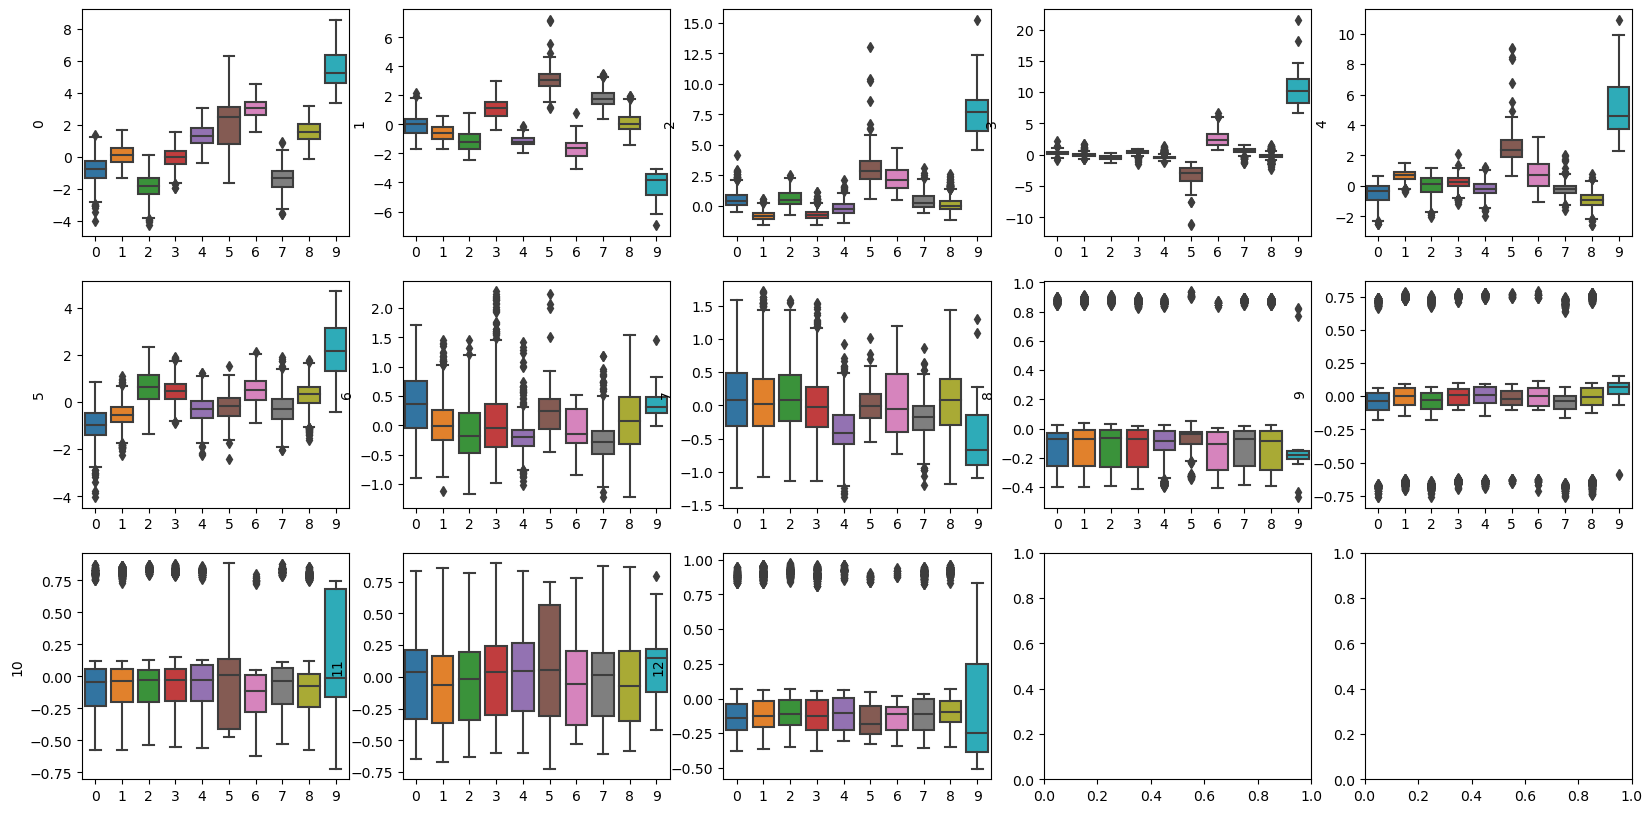

In [49]:
fig, axes = plt.subplots(nrows = 3, ncols = 5, figsize = (20, 10))
for i, ax in enumerate(zip(X_kmeans_pca_df.iloc[:,:13].columns.values, fig.axes)):
    sns.boxplot(y = X_kmeans_pca_df[ax[0]], x = kmeans_pca.labels_, ax = ax[1])

## ANN Model

In [50]:
def create_model5(neurons = 0):
    model = Sequential()
    model.add(Input(shape = (22, )))
    model.add(Dense(neurons, activation = 'relu', kernel_constraint = max_norm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation = 'sigmoid'))
    optimizer = SGD(learning_rate = 0.1, momentum = 0.1)
    model.compile(loss = 'binary_crossentropy', optimizer = optimizer, metrics = ['accuracy'])
    return model

neurons = [1, 5, 10, 15, 20, 25, 30]

# Create a list to hold the results
results = []

# Iterate over the learning rates and momentums
for n in neurons:
    # Create the KerasClassifier
    nnc5_model = KerasClassifier(build_fn=create_model5, batch_size=10, epochs=100, verbose=0, neurons = n)
    
    # Perform K-fold cross-validation and get train and test scores
    cv_results = cross_validate(nnc5_model, X_train_kmeans_pca, c_train.values.ravel(), cv=5,
                                return_train_score=True, return_estimator=True)

    train_scores = cv_results['train_score']
    test_scores = cv_results['test_score']

    # Calculate the mean of the scores
    mean_train_score = np.mean(train_scores)
    mean_test_score = np.mean(test_scores)

    # Append the result to the list
    results.append((n, mean_train_score, mean_test_score))


# Convert to DataFrame and Print the results
nnc5_df = pd.DataFrame(results, columns = ['neurons', 'train_score', 'test_score'])

Best Parameters: {Neurons [1] }
Best Cross-Validation Accuracy: 0.73


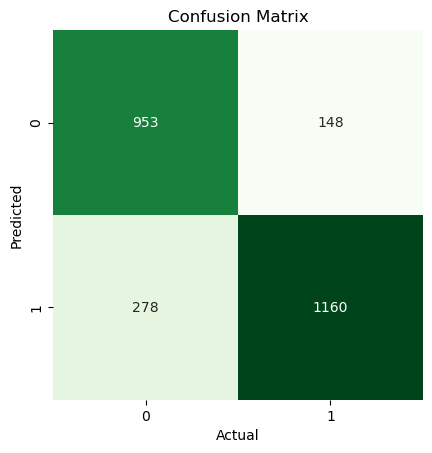

Accuracy: 0.83
Sensitivity: 0.89
Specificity: 0.77


In [51]:
# Find the maximum score value
max_score = nnc5_df['test_score'].max()

# Filter the rows with the maximum score value
best_nnc5 = nnc5_df[nnc5_df['test_score'] == max_score]

# Extract the 'pred' column and convert it to a numpy array
best_n = best_nnc5['neurons'].values.ravel()

print('Best Parameters: {Neurons', best_n, '}')
print('Best Cross-Validation Accuracy: {:.2f}'.format(max_score))

nnc5 = KerasClassifier(build_fn=create_model5, batch_size=10, epochs=100, verbose=0, neurons = best_n)

nnc5.fit(X_train_kmeans_pca, c_train.values.ravel())

pred_nnc5 = nnc5.predict(X_test_kmeans_pca)

cm_nnc5 = confusion_matrix(c_test, pred_nnc5)
tn, fp, fn, tp = cm_nnc5.ravel()

ax = sns.heatmap(cm_nnc5.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_nnc5)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))